# Whitening and Binning Analysis

In [1]:
import os
print(f'Current working dir:\t {os.getcwd()}')
from pathlib import Path

from datetime import datetime
# from datetime import timedelta

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch

%matplotlib widget

Current working dir:	 c:\GitRepos\various-data-analysis\timeseries-analysis


In [2]:
# filename = Path("Rocni_zprava_o_trhu_2020_V0.csv")
# root_data = Path("C:/DATA_FAST/electricity")
# cols_from_header = pd.read_csv(root_data / filename, nrows=0).columns.tolist()
# data_raw = pd.read_csv(root_data / filename, parse_dates=['Den']) #.drop(columns=['payment_id'])

filename = Path("ASTRO.csv")
root_data = Path(r"C:\DATA_FAST\benchmark_datasets")
data_raw = pd.read_csv(root_data / filename, names=['vals']) #.drop(columns=['payment_id'])
# read only header first for prep on parsing and stuff
data_raw = data_raw.dropna()
data_raw['vals'] = (data_raw['vals'] - data_raw['vals'].mean())/data_raw['vals'].std()


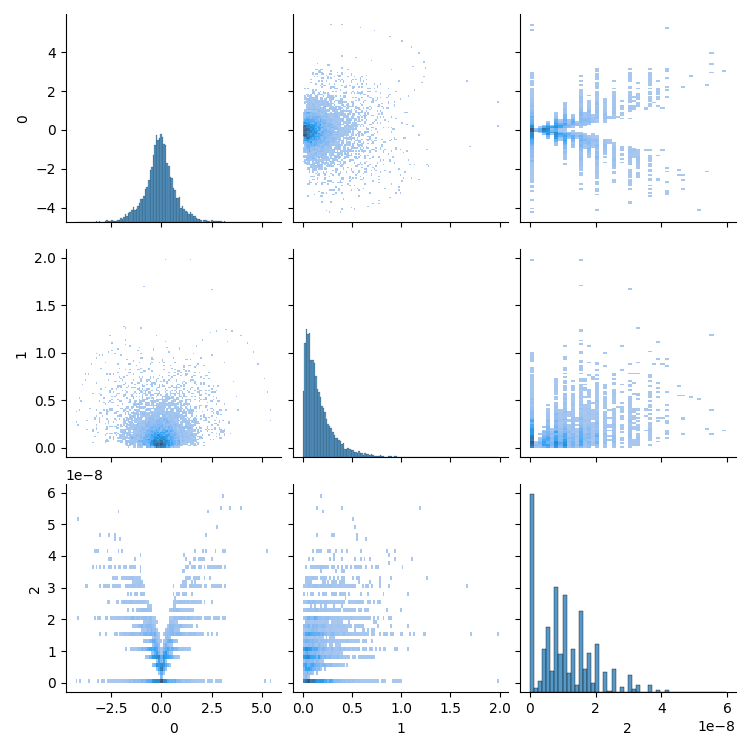

In [4]:
# T = 100
# N = 10000
# t = torch.linspace(0, T, N)
# prices = 0.1*torch.randn(N) + ( torch.sin(t) + torch.cos(5*t) )
# prices =( torch.sin(t) + torch.cos(5*t) ) * (torch.sin(t))
# prices = torch.tensor(data_raw['CZK/MWh'])
# prices = torch.tensor(data_raw['CZK/MWh'].diff())

# prices = torch.tensor(data_raw['vals'][0:10000])
# windows = prices.unfold(0, 3, 1)
prices = torch.tensor(data_raw['vals'][0:10000])
unfold = prices.unfold(0, 5, 1)
windows = torch.stack([
    unfold.mean(dim=1),
    unfold.std(dim=1),
    (unfold-unfold.mean(dim=1, keepdim=True)).sum(dim=1).sqrt()
], dim=1)
df2 = pd.DataFrame(windows.numpy())

# fig, ax = plt.subplots()
sns.pairplot(data=df2, kind='hist')

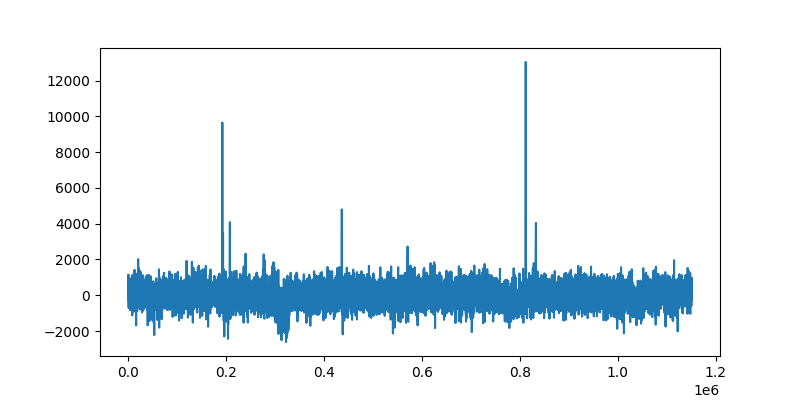

In [31]:
(unfold-unfold.mean(dim=1, keepdim=True)).shape

mot1 = torch.tensor(data_raw.iloc[812060:812200].to_numpy()).squeeze()
res =np.convolve(data_raw['vals'].to_numpy(), mot1.flip(0).numpy())

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(res)

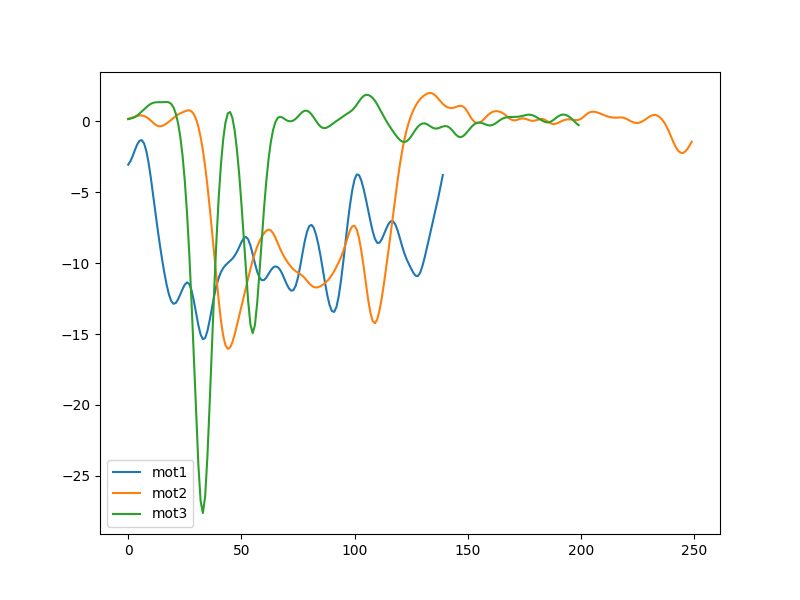

In [36]:
mot2 = data_raw.iloc[192150:192400]
mot3 = data_raw.iloc[436300:436500]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(np.arange(mot1.shape[0]), mot1, label='mot1')
ax.plot(np.arange(mot2.shape[0]), mot2, label='mot2')
ax.plot(np.arange(mot3.shape[0]), mot3, label='mot3')
ax.legend()


c:\GitRepos\python-libraries\.venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<AxesSubplot:>

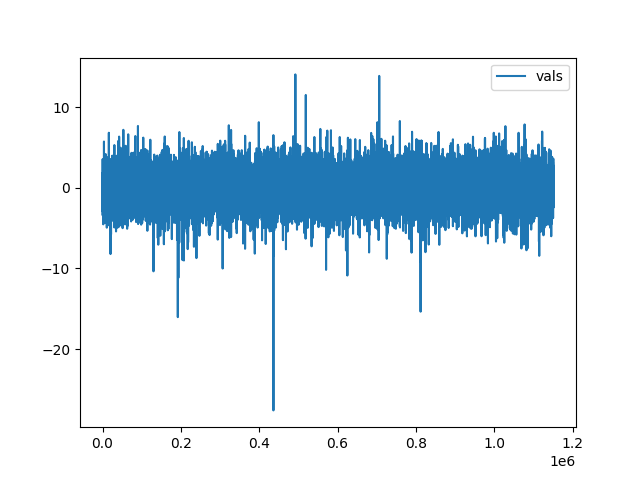

In [37]:
data_raw.describe()
data_raw.plot()

In [27]:
# prices = torch.tensor(data_raw['CZK/MWh'])
# prices = torch.tensor(data_raw['CZK/MWh'].diff())
# windows = prices.unfold(0, 3, 1)
mean = windows.mean(dim=0, keepdim=True)
w_cov = (windows-mean).T.cov(correction=1)
Linv = torch.linalg.cholesky(w_cov).inverse()

windows_white = Linv@(windows-mean).T
# windows_white.cov()
# windows_white.mean(dim=1)
print(windows_white.cov().eig())

torch.return_types.eig(
eigenvalues=tensor([[1.0000, 0.0000],
        [1.0000, 0.0000]], dtype=torch.float64),
eigenvectors=tensor([], dtype=torch.float64))


In [28]:
# prices = torch.tensor(data_raw['CZK/MWh'])
# prices = torch.tensor(data_raw['CZK/MWh'].diff())
# windows = prices.unfold(0, 3, 1)
mean = windows.mean(dim=0, keepdim=True)
w_cov = (windows-mean).T.cov(correction=1)
u, s, vt = torch.linalg.svd(w_cov)
print(f'S: {s}')

W = torch.diag(s.sqrt().reciprocal())@vt
# W = vt
# windows_white = v.H@torch.diag(s.reciprocal())@(windows-mean).T 
windows_white = W@(windows-mean).T
windows_white.cov().eig()
# windows_white.mean(dim=1)
# print(s)
# v.shape

S: tensor([0.6972, 0.0282], dtype=torch.float64)


torch.return_types.eig(
eigenvalues=tensor([[1.0000, 0.0000],
        [1.0000, 0.0000]], dtype=torch.float64),
eigenvectors=tensor([], dtype=torch.float64))

In [17]:
import math
# windows = prices.unfold(0, 3, 1)
mean = windows.mean(dim=0, keepdim=True)
# w_cov = (windows-mean).T.cov(correction=1)

u, s, vt = torch.linalg.svd((windows-mean), full_matrices=False)
print(f'S: {s}')

W = math.sqrt(windows.size(0)-1)*torch.diag(1/s)@vt
windows_white = W@(windows-mean).T
print(windows_white.cov().eig())

# windows_white = (u@vt)
# (u@vt).T.cov().eig()
windows_white.shape

S: tensor([83.4774, 16.7791], dtype=torch.float64)
torch.return_types.eig(
eigenvalues=tensor([[1.0000, 0.0000],
        [1.0000, 0.0000]], dtype=torch.float64),
eigenvectors=tensor([], dtype=torch.float64))


torch.Size([2, 9996])

(9996, 2)

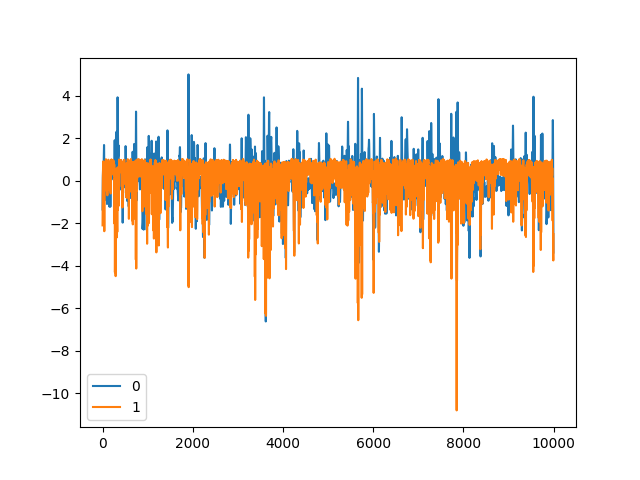

In [18]:
df_white = pd.DataFrame(windows_white.T.numpy())
df_white.plot()
df_white.shape

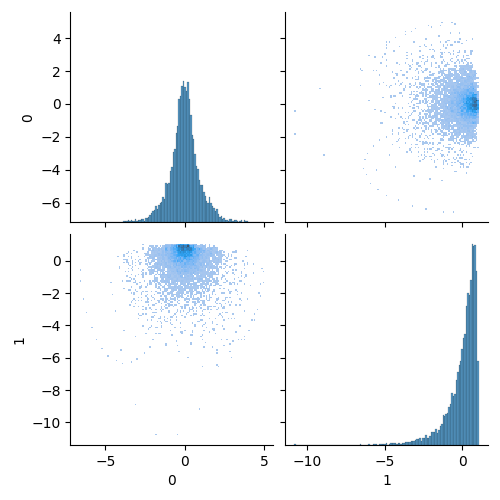

In [21]:
sns.pairplot(data=df_white, kind='hist')

<AxesSubplot:ylabel='Proportion'>

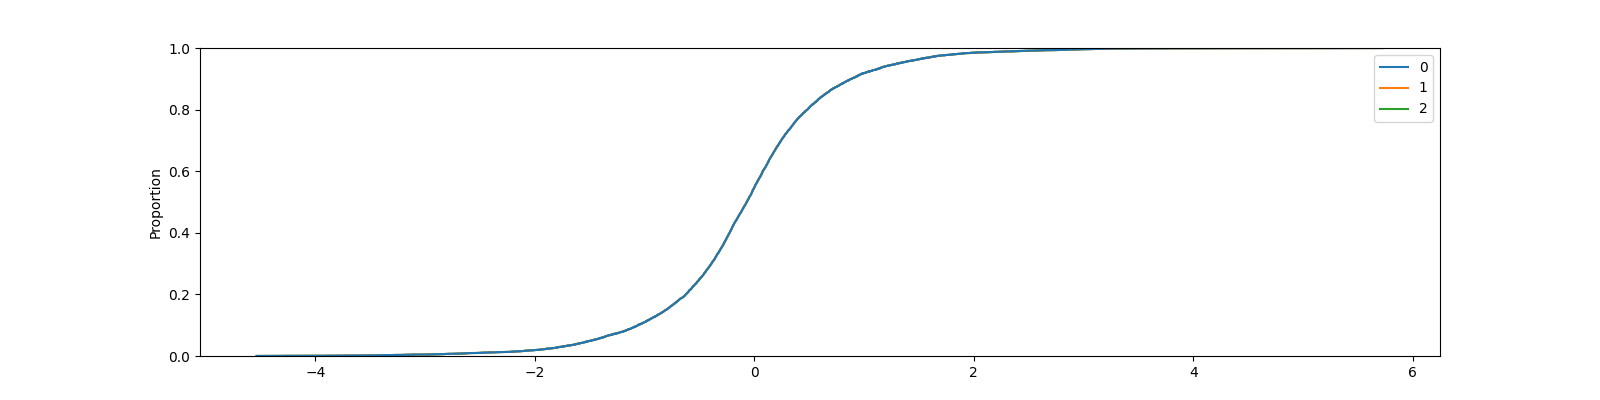

In [20]:

windows = prices.unfold(0, 3, 1)
w_cov = windows.cov()
u, s, v = torch.svd(windows - windows.mean(dim=0, keepdim=True))

df2 = pd.DataFrame(windows.numpy())

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
# sns.pairplot(data=df2, kind='hist')
sns.ecdfplot(data=df2, ax=ax)

In [ ]:
torch.std_mean(windows, dim=0)

In [ ]:
import torch.distributions as dist

In [ ]:
d = mean.size(1)
mvn = dist.MultivariateNormal(loc=torch.zeros(d), covariance_matrix=torch.eye(d))

t = torch.linspace(-10, 10, 100)
y = mvn.cdf(t)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(t, y)